### Content:
- Train text classifier incorporating pretrained Word Embeddings

- Blog: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568#c533/
- Notebook: https://github.com/susanli2016/NLP-with-Python/blob/master/Text%20Classification%20model%20selection.ipynb

In [1]:
from notebook_utils import *
init()

Execute the following jupyter commands manually:
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2


In [2]:
import gc
import glob
from datetime import datetime, timedelta
import itertools

import gensim
from gensim.models import Word2Vec
from scipy.sparse import issparse
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
import spacy
from spacy import displacy

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

### Load Data

In [4]:
from src.datasets import NyseSecuritiesDataset
from src.datasets import NyseStocksDataset
import src.nlp_utils as nlp_utils
import src.text_classification_utils as tc_utils

HOME = ".."
DATA_DIR = "data"
NEWS = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v5.csv")
OCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "occurrences.csv")
COOCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "cooccurrences.csv")
PRICES = os.path.join(HOME, DATA_DIR, "nyse", "prices-split-adjusted.csv")
GOOGLE_NEWS_EMBEDDING = os.path.join(HOME, DATA_DIR, "embeddings", "GoogleNews-vectors-negative300.bin.gz")
WIKI_NEWS_EMBEDDING = os.path.join(HOME, DATA_DIR, "embeddings", "wiki-news-300d-1M.vec")
NEWS_AVERAGED_GOOGLE_WV = os.path.join(HOME, DATA_DIR, "preprocessed", "news-averaged-google-wv.csv")

stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices-split-adjusted.csv'); stocks_ds.load()
securities_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv'); securities_ds.load()
companies = securities_ds.get_all_company_names()  # List[Tuple[symbol, name]]

occs_per_article = tc_utils.get_occs_per_article(OCCS)

time: 34.6 s


#### Define final test run

In [164]:
all_news = pd.read_csv(NEWS, index_col=0)

time: 24.8 s


In [5]:
# Also contains prices from train for look back
stocks_test_ds = NyseStocksDataset(file_path=PRICES, only_test=True, load=True)
all_news = pd.read_csv(NEWS, index_col=0)

def final_test(pipe, look_back=0, forecast=30, epsilon_daily_label=0.01, epsilon_overall_label=0.05, min_occurrences=5):
    # 60k articles
    news_test = tc_utils.load_news_clipped(stocks_test_ds, look_back, forecast, news=all_news)
    rel_article_tuples_test = tc_utils.get_relevant_articles(
        news_test, occs_per_article, securities_ds, min_occ=min_occurrences)
    rel_article_tuples_test = [x for x in rel_article_tuples_test
                               if stocks_test_ds.is_company_available(x[0])]

    X_test = np.array([nlp_utils.get_plain_content(x[1]) for x in rel_article_tuples_test])
    y_test = tc_utils.get_discrete_labels(
        rel_article_tuples_test, stocks_test_ds, look_back=look_back, forecast=forecast,
        epsilon_daily_label=epsilon_daily_label, epsilon_overall_label=epsilon_overall_label)
    print('Test distribution:', ''.join([f'"{cls}": {sum(y_test == cls)} samples; ' for cls in [1, -1, 0]]))

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, mcc, y_pred

time: 1min


In [168]:
all_vectors_df = pd.read_csv(NEWS_AVERAGED_GOOGLE_WV, index_col=0)

time: 201 ms


In [23]:
epsilon_daily_label = 0.01
epsilon_overall_label = 0.05
min_occurrences = 5  # for one company
max_articles = 20000 # with min_occ=1 we get up to 25k

# Deterministic approach
algorithm = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs', max_iter=10000)
time_delta = 30

news = all_news
file_path = None

time: 164 ms


In [78]:
stock_dates = stocks_ds.get_all_prices().date.unique()
stock_dates.sort()
look_back = abs(min(time_delta, 0))
forecast = abs(max(time_delta, 0))
print('-'*40, '\n', f'look_back={look_back}; forecast={forecast}')

# Load articles for fitting range depending on look back and forecast
news = tc_utils.load_news_clipped(stocks_ds, look_back, forecast, news=all_news, file_path=file_path)

# Get all articles with enough occurrences
rel_article_tuples = tc_utils.get_relevant_articles(
    news, occs_per_article, securities_ds, min_occ=min_occurrences)
rel_article_tuples = (x for x in rel_article_tuples if stocks_ds.is_company_available(x[0]))
if max_articles is not None:
    rel_article_tuples = itertools.islice(rel_article_tuples, max_articles)
rel_article_tuples = list(rel_article_tuples)
news = None  # Free space if possible

assert len(rel_article_tuples) > 0, 'No relevant article tuples'
assert len(rel_article_tuples) > 100, 'Not enough relevant article tuples'

discrete_labels = tc_utils.get_discrete_labels(
    rel_article_tuples, stocks_ds, look_back=look_back, forecast=forecast,
    epsilon_daily_label=epsilon_daily_label, epsilon_overall_label=epsilon_overall_label)
print('Distribution:', ''.join([f'"{cls}": {sum(discrete_labels == cls)} samples; ' for cls in [1, -1, 0]]))

---------------------------------------- 
 look_back=0; forecast=30


Distribution: "1": 2447 samples; "-1": 2832 samples; "0": 2698 samples; 
time: 10min 11s


In [190]:
indizes = [x[1].name for x in rel_article_tuples]
vectors_df = all_vectors_df.loc[indizes]
# assert all(x.iloc[-1] == vectors_df.loc[news.index[-1]])
X_train, y_train, X_test, y_test = tc_utils.split_shuffled(vectors_df, discrete_labels, seed=42)

time: 3.88 s


In [191]:
# algorithm = GaussianNB()  # MultinomialNB, RandomForestClassifier, SGDClassifier, GaussianNB
algorithm = LogisticRegression(C=2.0, multi_class='auto', solver='lbfgs', max_iter=10000)
pipe = Pipeline([('clf', algorithm)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

train_acc = tc_utils.accuracy_score(y_train, y_train_pred)
train_mcc = tc_utils.matthews_corrcoef(y_train, y_train_pred)

acc = tc_utils.accuracy_score(y_test, y_pred)
mcc = tc_utils.matthews_corrcoef(y_test, y_pred)

print(acc, mcc)

0.3558897243107769 0.030749612279524535
time: 1.5 s


TODO: https://robjhyndman.com/hyndsight/tscv/

TODO: https://www.tensorflow.org/guide/summaries_and_tensorboard

Visualize Word Embedding

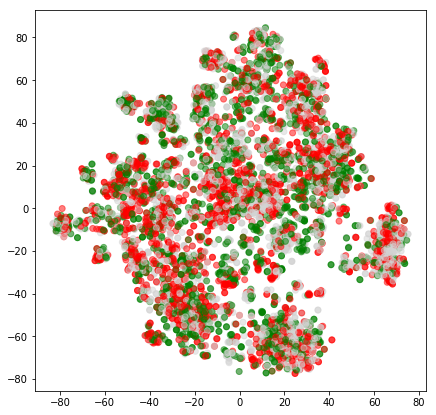

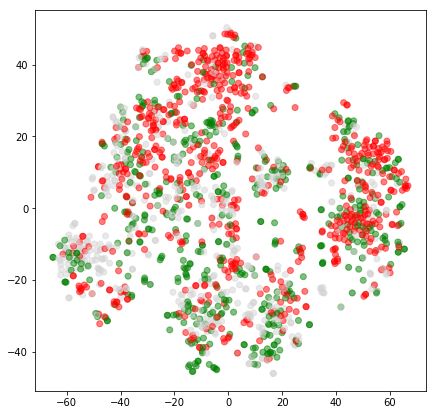

time: 2min 36s


In [234]:
import sys
import codecs
 
from sklearn.manifold import TSNE

color_mappping = {
    -1: 'red',
    0: 'lightgray',
    1: 'green'
}

def calculate_tsne(word_vectors):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(word_vectors)
    return Y

def show_tsne(positions, labels):
    fig, ax = plt.subplots(figsize=(7, 7))
    colors = [color_mappping[int(x)] for x in labels]
    ax.scatter(positions[:, 0], positions[:, 1], color=colors, alpha=0.5)
    return fig, ax

positions = calculate_tsne(X_train)
fig, ax = show_tsne(positions, y_train)
fig.savefig('tsne-averaged-wv-train.pdf')

positions = calculate_tsne(X_test)
fig, ax = show_tsne(positions, y_test)
fig.savefig('tsne-averaged-wv-test.pdf')

# TODO:
- Find good samples from red and green clouds
- Plot with acc & val_acc for features from 50 to 5000D (https://nlp.stanford.edu/pubs/glove.pdf)
- Show misleading improvement by split_after_shuffle=True (will fail von the test set)

### News v5 - Only Articles Useful for Text Classification

In [ ]:
old_news_path = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v4.csv")
# Start at 46481 (Start date of stock prices - 04.01.2010)
all_news = pd.read_csv(old_news, index_col=0, skiprows=range(1, 46481))
all_news = all_news[~all_news.content.isna()]
all_news = all_news[all_news.content.str.len() > 200]
# Short message, longest article contains 254 letters
all_news = all_news[~all_news.content.str.contains('TRADING TO RESUME')]
# all_news.to_csv(os.path.join(HOME, DATA_DIR, "preprocessed", "news-v5.csv"))

### Generate Word Vectors

In [162]:
wv = gensim.models.KeyedVectors.load_word2vec_format(wv_path, binary=True)
wv.init_sims(replace=True)
transformer = tc_utils.W2VTransformer(wv)
vectors = transformer.transform(all_news.content.values)
# All vectors are successfully created (no None values)
assert sum([not isinstance(x, np.ndarray) for x in vectors]) == 0
all_vectors_df = pd.DataFrame(vectors, index=all_news.index)
# all_vectors_df.to_csv(NEWS_AVERAGED_GOOGLE_WV)

time: 1min 7s
